# Example training and evaluation of LightGBM model using the CESNET-TLS-Year22 dataset

In [ ]:
import sys
!{sys.executable} -m pip install cesnet-datazoo lightgbm scikit-learn matplotlib seaborn

Download the CESNET-TLS-Year22 dataset if it is not already downloaded, enable logging, and set configuration.

In [5]:
import logging
from cesnet_datazoo.datasets import CESNET_TLS_Year22
from cesnet_datazoo.config import DatasetConfig, ValidationApproach

logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s][%(name)s][%(levelname)s] - %(message)s")

dataset = CESNET_TLS_Year22(data_root="data/CESNET-TLS-Year22/", size="XS")
common_params = {
    "dataset": dataset,
    "train_period_name": "M-2022-6",
    "val_approach": ValidationApproach.SPLIT_FROM_TRAIN,
    "train_val_split_fraction": 0.2,
}
dataset_config = DatasetConfig(**common_params)
dataset.set_dataset_config_and_initialize(dataset_config)

[2024-07-17 17:08:41,693][cesnet_datazoo.pytables_data.indices_setup][INFO] - Processing train indices
[2024-07-17 17:08:41,992][cesnet_datazoo.pytables_data.pytables_dataset][INFO] - Reading app and SNI columns for table /flows/D20220601 took 0.08 seconds
[2024-07-17 17:08:42,075][cesnet_datazoo.pytables_data.pytables_dataset][INFO] - Reading app and SNI columns for table /flows/D20220602 took 0.08 seconds
[2024-07-17 17:08:42,149][cesnet_datazoo.pytables_data.pytables_dataset][INFO] - Reading app and SNI columns for table /flows/D20220603 took 0.07 seconds
[2024-07-17 17:08:42,171][cesnet_datazoo.pytables_data.pytables_dataset][INFO] - Reading app and SNI columns for table /flows/D20220604 took 0.02 seconds
[2024-07-17 17:08:42,196][cesnet_datazoo.pytables_data.pytables_dataset][INFO] - Reading app and SNI columns for table /flows/D20220605 took 0.02 seconds
[2024-07-17 17:08:42,276][cesnet_datazoo.pytables_data.pytables_dataset][INFO] - Reading app and SNI columns for table /flows/D

Load training and validation dataframes and create LightGBM datasets.

In [6]:
import lightgbm as lgb
from cesnet_datazoo.constants import APP_COLUMN

feature_names = dataset_config.get_feature_names(flatten_ppi=True)
train_df = dataset.get_train_df(flatten_ppi=True)
val_df = dataset.get_val_df(flatten_ppi=True)
train_labels = train_df.pop(APP_COLUMN)
val_labels = val_df.pop(APP_COLUMN)

lgb_train_dataset = lgb.Dataset(data=train_df, label=train_labels, feature_name=feature_names)
lgb_val_dataset = lgb.Dataset(data=val_df, label=val_labels, feature_name=feature_names)

print(f"Loaded {len(train_df)} train samples")
print(f"Loaded {len(val_df)} validation samples")

Loading data from dataloader


100%|██████████| 3867/3867 [00:22<00:00, 172.12it/s] 


Loading data from dataloader


100%|██████████| 91/91 [00:07<00:00, 12.89it/s]


Loaded 742336 train samples
Loaded 185585 validation samples


Train the LightGBM model for 20 iterations.

In [7]:
lgb_params = {
    "task": "train",
    "objective": "multiclass",
    "num_class": dataset.get_num_classes(),
    "metric": "multi_error",
    "num_leaves": 320,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "lambda_l2": 4,
    "verbose": -1,
}

validation_metrics = {}
lgb_model = lgb.train(
    params=lgb_params,
    num_boost_round=20,
    train_set=lgb_train_dataset,
    valid_sets=[lgb_val_dataset],
    callbacks=[lgb.log_evaluation()]
)
best_score = lgb_model.best_score["valid_0"]["multi_error"]
print(f"The best validation score is {best_score:.3f}")

[1]	valid_0's multi_error: 0.212911
[2]	valid_0's multi_error: 0.165396
[3]	valid_0's multi_error: 0.138583
[4]	valid_0's multi_error: 0.120209
[5]	valid_0's multi_error: 0.108473
[6]	valid_0's multi_error: 0.099868
[7]	valid_0's multi_error: 0.0932026
[8]	valid_0's multi_error: 0.0881106
[9]	valid_0's multi_error: 0.0835628
[10]	valid_0's multi_error: 0.0798394
[11]	valid_0's multi_error: 0.0764286
[12]	valid_0's multi_error: 0.0737721
[13]	valid_0's multi_error: 0.0709217
[14]	valid_0's multi_error: 0.0685292
[15]	valid_0's multi_error: 0.0665302
[16]	valid_0's multi_error: 0.0645203
[17]	valid_0's multi_error: 0.0628068
[18]	valid_0's multi_error: 0.0611903
[19]	valid_0's multi_error: 0.0597462
[20]	valid_0's multi_error: 0.0584799
The best validation score is 0.058


## Per-month evaluation

Training of the model was done on samples from the month of June of CESNET-TLS-Year22. Now, let's evaluate the model on the following three months.

For each month:

1. Create ``DatasetConfig`` and set the month as ``test_period_name``.
2. Load test dataframe.
3. Predict applications with the trained LightGBM model.
4. Compute classification accuracy.


Testing on period M-2022-7
Loading data from dataloader


100%|██████████| 292/292 [00:07<00:00, 39.02it/s] 


Loaded 596841 test samples
Classification accuracy for M-2022-7 is 0.892

Testing on period M-2022-8
Loading data from dataloader


100%|██████████| 302/302 [00:07<00:00, 39.76it/s] 


Loaded 618472 test samples
Classification accuracy for M-2022-8 is 0.852

Testing on period M-2022-9
Loading data from dataloader


100%|██████████| 371/371 [00:08<00:00, 45.54it/s] 


Loaded 758490 test samples


[2024-07-17 17:17:32,542][matplotlib.category][INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-07-17 17:17:32,548][matplotlib.category][INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Classification accuracy for M-2022-9 is 0.807


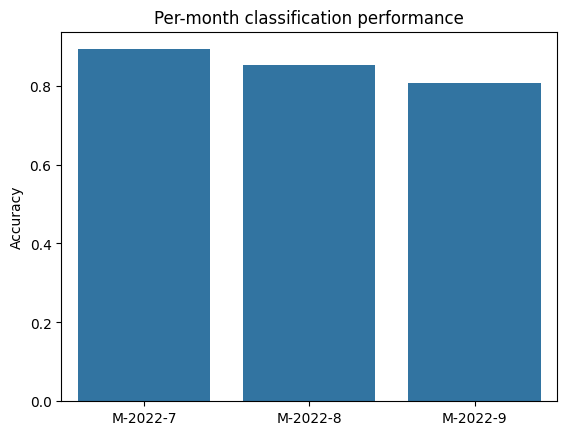

In [9]:
from sklearn.metrics import accuracy_score
import seaborn

test_periods = ["M-2022-7", "M-2022-8", "M-2022-9"]
per_month_acc = []
for period in test_periods:
    print(f"\nTesting on period {period}")
    dataset_config = DatasetConfig(**common_params, test_period_name=period)
    dataset.set_dataset_config_and_initialize(dataset_config)
    test_df = dataset.get_test_df(flatten_ppi=True)
    print(f"Loaded {len(test_df)} test samples")
    true_labels = test_df.pop(APP_COLUMN)
    preds = lgb_model.predict(test_df).argmax(axis=1)
    acc = accuracy_score(true_labels, preds)
    per_month_acc.append(acc)
    print(f"Classification accuracy for {period} is {acc:.3f}")

seaborn.barplot(y=per_month_acc, x=test_periods).set(title="Per-month classification performance", ylabel="Accuracy");